In [2]:
import os
import pandas as pd
import numpy as np
import math
import empyrical as empy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


from sklearn.metrics import accuracy_score, precision_score, explained_variance_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
csv = './data/XAU_USD.csv'
start = '1985'
end = '2021'

In [4]:
sma = lambda x, y: x.rolling(int(y)).mean()

ewma = lambda x, y: x.ewm(span=y).mean()

def s(x,x0,x1,y0=0,y1=1,d=np.nan):
    if x>=x1:
        return y1
    if x<x0:
        return y0
    return d

In [5]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()

In [6]:
price = pd.read_csv(csv, index_col=0)['adj_close']
price.index = pd.to_datetime(price.index)

true_ret = price.pct_change()
true_yret = empy.aggregate_returns(true_ret, convert_to='yearly')
true_mret = empy.aggregate_returns(true_ret, convert_to='monthly')

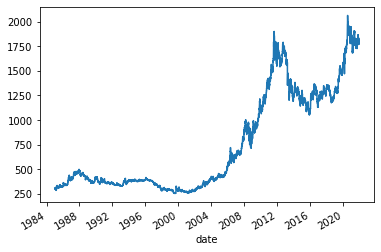

<AxesSubplot:xlabel='date'>

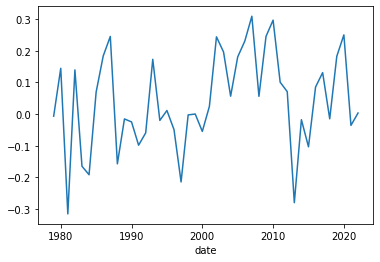

In [7]:
price[start:end].plot()
plt.show()
# true_mret.plot()
# plt.show()
true_yret.plot()

In [8]:
true_up = (true_ret>=0)
true_up

date
1979-12-27    False
1979-12-28    False
1980-01-01     True
1980-01-02     True
1980-01-03     True
              ...  
2022-02-04     True
2022-02-07     True
2022-02-08     True
2022-02-09     True
2022-02-10     True
Name: adj_close, Length: 10921, dtype: bool

<AxesSubplot:>

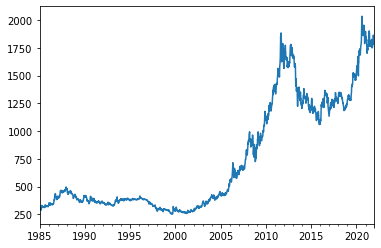

In [9]:
period_index = price.index.to_period('W')
weeklyprice = price.groupby(period_index).nth(-1)
weeklyprice.index = [idx.end_time.date() for idx in weeklyprice.index]
weeklyprice.index = pd.to_datetime(weeklyprice.index)
weeklyprice[start:end].plot()

In [10]:
def other_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(other_metric).T
    
    pred_up = (ret!=0)*1
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    idx_tmp = pred_up.index & true_up.index
    true_up_tmp = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up_tmp, pred_up)
    prec = precision_score(true_up_tmp, pred_up)
    
    true_up_pct = true_ret.reindex(idx_tmp)
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    mse = mean_squared_error(true_up_pct_scaled, pred_up)
    
    se = pd.Series(dtype='float64')
    
    se['highlight_ratio'] = highlight_ratio
    se['flip_ratio'] = flip_ratio
    se['accu'] = accu
    se['prec'] = prec
    se['mse'] = mse
    
    return se


def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    return se

In [11]:
def print_all_result(ret_df, proba_df=None, topn=10, strategy_list_sel=None, base_case=None):
    
    display('{} to {}'.format(ret_df.index[0], ret_df.index[-1]))
    
    column_selected = ['annual_return', 'sharpe_ratio', 'max_drawdown', 'avg_drawdown', 'return/avgdd',]
    empy_metric_tmp = empy_metric(ret_df).sort_values('sharpe_ratio')
    if strategy_list_sel is None:

        strategy_list_sel = list(empy_metric_tmp.index)

        strategy_list_sel = strategy_list_sel[-topn:]

    if 'buy_and_hold' in strategy_list_sel:
        strategy_list_sel = [x for x in strategy_list_sel if x !='buy_and_hold']
    
    base_list = ['buy_and_hold']
    if base_case is not None:
        for bc in base_case:
            if bc == 'buy_and_hold':
                continue
            else:
                if bc not in strategy_list_sel:
                    base_list.append(bc)
    strategy_list_sel = base_list+strategy_list_sel
    
    other_metric_tmp = other_metric(ret_df)
    
    display(other_metric_tmp.loc[strategy_list_sel[1:]].iloc[:,:5])
    display(empy_metric_tmp.loc[strategy_list_sel][column_selected])
    
    fig, ax = plt.subplots(figsize=(20,15))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret_df[strategy_list_sel].shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    (1+ret_df[strategy_list_sel]).cumprod().plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()
    
#     cvals  = [0, 0.5, 1]
#     colors = ["red", 'white', "lawngreen"]
#     cmap = LinearSegmentedColormap.from_list("", colors)
#     norm=plt.Normalize(min(cvals),max(cvals))
#     tuples = list(zip(map(norm,cvals), colors))
#     cmap = LinearSegmentedColormap.from_list("", tuples)
#     sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm
#     sm.set_array([])

    
    if proba_df is None:
        return strategy_list_sel

    alpha = 1
    dot_size = 20
    
    base_cumret = (1+ret_df['buy_and_hold']).cumprod().apply(math.log)
    base_cumret.name = 'buy_and_hold'
    
    for case in strategy_list_sel:
        if case not in proba_df.columns:
            continue
        print("====================================", case)
#         try:
        if True:
            df_temp = pd.concat([ret_df[case], proba_df[case]],1,keys=['return','pred prob']).dropna()

    #         df_temp['log return'] = (1+df_temp['return']).apply(math.log)
    #         df_temp['cumulative return'] = (1+df_temp['return']).cumprod()-1
            df_temp['log cumulative return'] = (1+df_temp['return']).cumprod().apply(math.log)

            z_ret = ret_df[case]/ret_df[case].std()
            z_prod = (proba_df[case]-0.5)/proba_df[case].std()
            df_temp['score'] = 3-abs(z_ret-z_prod)

            df_temp = df_temp.reset_index()
            df_temp['date'] = pd.to_datetime(df_temp['date'])
            
#             display(df_temp)
            
            plot_hue = 'pred prob'
        
            cvals  = [0,0.5,1]
            colors = ["red","white","lawngreen"]
            norm = plt.Normalize(min(cvals),max(cvals))
            tuples = list(zip(map(norm,cvals), colors))
            cmap_prob = LinearSegmentedColormap.from_list("", tuples)
            sm_prob = plt.cm.ScalarMappable(cmap=cmap_prob, norm=norm)
            sm_prob.set_array([])
            
            fig, ax = plt.subplots(figsize=(20,15))
            ax = sns.scatterplot(data=df_temp, x='date', y='log cumulative return', hue=plot_hue,
                                 #hue='score', alpha=0.5, palette=cmap, s=20)
                                 alpha=0.5, palette=cmap_prob, s=dot_size
#                                  cmap=cmap_prob
                                )
            base_cumret.plot(ax=ax)

            ax.set_xlim([df_temp['date'].iloc[0], df_temp['date'].iloc[-1]])
            ax.get_legend()#.remove()
#             ax.set_yscale("log")
            ax.figure.colorbar(sm_prob)
            ax.set_title("{} {}".format(case, plot_hue))
            plt.show()
            
            fig, ax = plt.subplots(figsize=(12,10))
            proba_df.loc[ret_df.index, case].plot(kind='bar', ax=ax, legend=False)
#             ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_title(case + ' proba')
            plt.show()
#         except Exception as e:
#             print(e)
#             continue
    
    
    return strategy_list_sel
    

In [91]:
true_up

date
1979-12-27    False
1979-12-28    False
1980-01-01     True
1980-01-02     True
1980-01-03     True
              ...  
2022-02-04     True
2022-02-07     True
2022-02-08     True
2022-02-09     True
2022-02-10     True
Name: true_ret, Length: 10921, dtype: bool

In [ ]:
total_return = lambda x: (1+x).prod()-1
true_ret.name = 'true_ret'

lookbacks = [1, 2, 3, 5, 8, 10, 15]
true_yret_roll_ret = pd.DataFrame()
for lookback in lookbacks:
    true_yret_rollN = true_ret.rolling(lookback*252).apply(total_return)
    true_yret_rollN.name = 'lookback{}Y_ret'.format(lookback)
    true_yret_roll_ret = pd.concat([true_yret_roll_ret, true_yret_rollN], axis=1)
true_yret_roll_ret = true_yret_roll_ret.dropna()
true_yret_roll_ret_pred = (true_yret_roll_ret > 0).astype(int).shift().dropna()
# true_yret_roll_ret_pred.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_ret_pred.index])
true_yret_roll_ret_pred

In [ ]:
price[true_yret_roll_ret.index].plot()
plt.show()

for col in true_yret_roll_ret.columns:
    tt = true_yret_roll_ret[col]
    tt.plot(title=col)
    plt.show()

In [ ]:
total_return = lambda x: (1+x).prod()-1
true_yret.name = 'true'

lookbacks = [1, 2, 3, 5, 8, 10, 15]
true_yret_roll_ret = pd.DataFrame()
for lookback in lookbacks:
    true_yret_rollN = true_yret.rolling(lookback).apply(total_return)
    true_yret_rollN.name = 'lookback{}Y_ret'.format(lookback)
    true_yret_roll_ret = pd.concat([true_yret_roll_ret, true_yret_rollN], axis=1)
true_yret_roll_ret = true_yret_roll_ret.dropna()
true_yret_roll_ret_pred = (true_yret_roll_ret > 0).astype(int).shift().dropna()
true_yret_roll_ret_pred.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_ret_pred.index])
true_yret_roll_ret_pred

In [ ]:
true_yret_3stage = pd.cut(true_yret, bins=[0, 0.3, 0.6, 1], right=True, labels=False).fillna(0)(true_yret >= 0).astype(int)

true_yret_roll_vote_pred = pd.DataFrame()
true_yret_roll_vote_proba = pd.DataFrame()
lookbacks = [3, 5, 8, 10, 15]
for lookback in lookbacks:
    true_yret_rollN = true_yret_up.rolling(lookback).mean()
    true_yret_rollN.name = 'lookback{}Y_vote'.format(lookback)
    true_yret_roll_vote_proba = pd.concat([true_yret_roll_vote_proba, true_yret_rollN], axis=1)

    pp = pd.cut(true_yret_rollN, bins=[0, 0.3, 0.6, 1], right=True, labels=False).fillna(0)
    pp.name = 'lookback{}Y_vote'.format(lookback)
    true_yret_roll_vote_pred = pd.concat([true_yret_roll_vote_pred, pp], axis=1)

true_yret_roll_vote_proba = true_yret_roll_vote_proba.shift().dropna()
true_yret_roll_vote_pred = true_yret_roll_vote_pred.shift().dropna()

# true_yret_roll_vote_pred.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_vote_pred.index])
# true_yret_roll_vote_proba.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_vote_proba.index])
true_yret_roll_vote_pred

In [ ]:
true_ret_roll_vote_proba = pd.DataFrame()
lookbacks = [1, 2, 3, 5, 8, 10, 15]
for lookback in lookbacks:
    true_yret_rollN = true_up.astype(int).rolling(lookback*252).mean()
    true_yret_rollN.name = 'lookback{}Y_vote'.format(lookback)
    # print("================================\n", true_yret_rollN)
    true_ret_roll_vote_proba = pd.concat([true_ret_roll_vote_proba, true_yret_rollN], axis=1)

true_ret_roll_vote_proba = true_ret_roll_vote_proba.dropna()
true_ret_roll_vote_proba

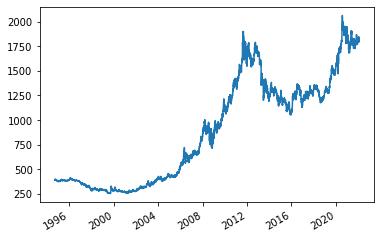

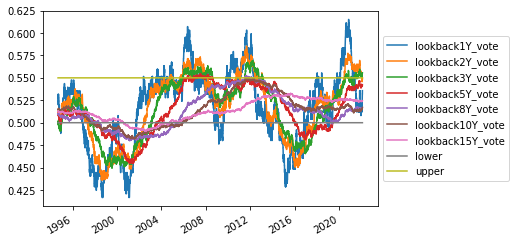

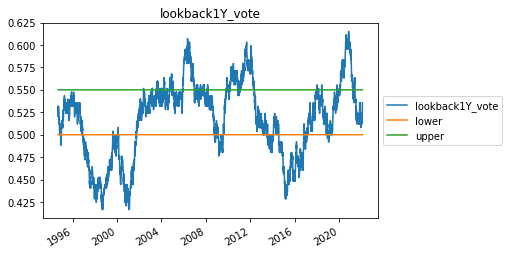

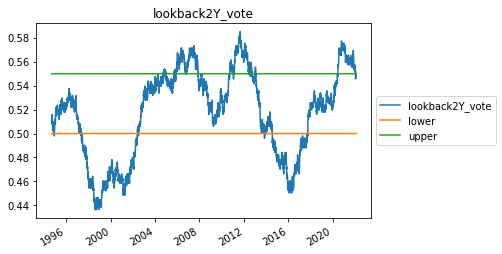

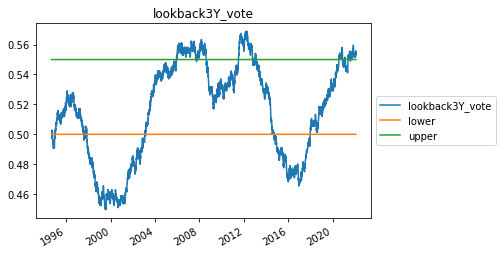

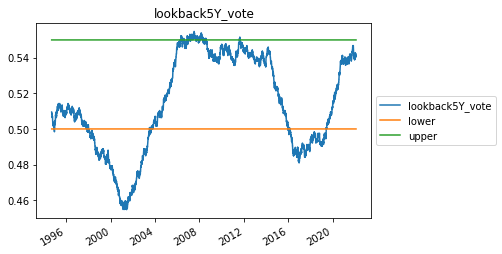

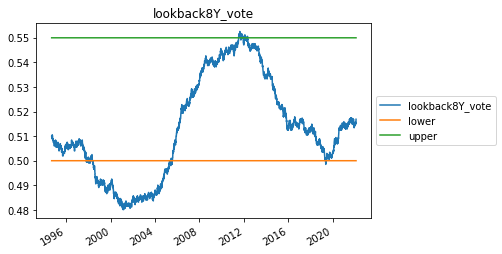

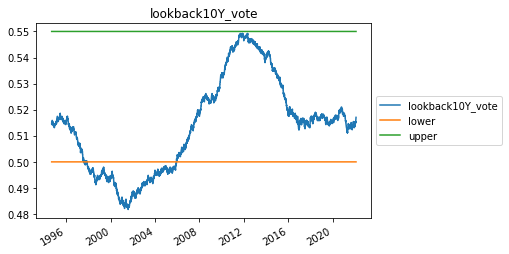

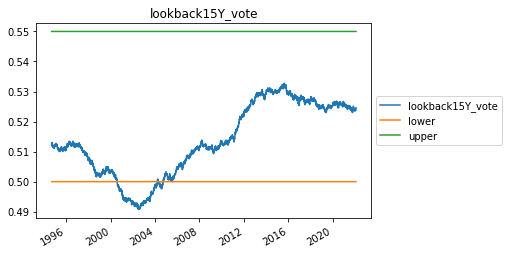

In [121]:
price[true_ret_roll_vote_proba.index].plot()
plt.show()

bounds = pd.DataFrame([[0.5, 0.55]] * len(true_ret_roll_vote_proba.index), index=tt.index, columns=['lower', 'upper'])
pd.concat([true_ret_roll_vote_proba, bounds], axis=1).plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

for col in true_ret_roll_vote_proba.columns:
    tt = true_ret_roll_vote_proba[col]
    pd.concat([tt, bounds], axis=1).plot(title=col).legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
# true_yret_roll_vote_pred
# true_yret_up

acc = pd.Series(index=true_yret_roll_vote_pred.columns)
for col in true_yret_roll_vote_pred.columns:
    acc[col] = accuracy_score(true_yret_up[true_yret_roll_vote_pred.index], true_yret_roll_vote_pred[col])
acc

In [66]:
preds = pd.DataFrame(1, columns=['buy_and_hold'], index=true_ret.index)
preds = pd.concat([preds, true_yret_roll_ret_pred, true_yret_roll_vote_pred], axis=1)
preds = preds.fillna(method='ffill')
preds = preds.loc[true_ret.index, :]
preds = preds['1994': end]
preds.shape

(7290, 15)

In [67]:
ret_sma_cross = preds.multiply(true_ret[preds.index], 0)
ret_sma_cross.shape

(7290, 15)

In [ ]:
strategy_list_sel = print_all_result(ret_sma_cross)